# Deep Learning Lession 5 - Sign Language


## 5.1 What the Data Looks Like

Before we start to build the deep learning network, the first thing I want to do is to see what the data looks like.
Our data set is a `*.npy` file which can be easily load by `numpy`.

In [1]:
%config IPCompleter.greedy=True

import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.autograd import Variable
from tqdm import tqdm
from skimage import transform
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import os


PATH = './Dataset/'

FILE_LIST = os.listdir(PATH)

X = []
Y = []

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


for dir in FILE_LIST:
    for file in os.listdir(f"{PATH}{dir}"):
        Y.append(int(dir))
        x = transform.resize(rgb2gray(plt.imread(f"{PATH}{dir}/{file}")), (64, 64))
        X.append(x)

plt.imshow(X[0], cmap="gray")

plt.show()

Y = np.array(Y)

weight =  np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
X_edge = [ndimage.convolve(x, weight, mode='constant', cval=1.0) for x in X]

X = np.array(X_edge).astype(np.float32)


/home/alovez/.conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<Figure size 640x480 with 1 Axes>

Now I want to know the number of each sign

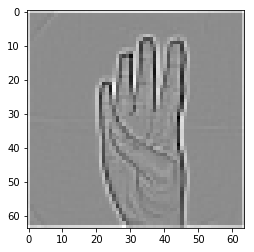

In [2]:
plt.imshow(X_edge[841], cmap="gray")

plt.show()

In [3]:
y_list = Y.tolist()
for i in range(10):
    print(i, y_list.count(i))

0 205
1 206
2 206
3 206
4 207
5 207
6 207
7 206
8 208
9 204


## 5.2 Data Pre-Processing

First we need a function to split the data to train set and test set.

In [4]:
def split_train_test_data(x_data, y_data, test_size):
    indices = random.sample(range(len(x_data)), test_size)
    test_x_data = []
    for i in indices:
        test_x_data.append(x_data[i])
    test_y_data = y_data.take(indices)
    x_data = np.delete(x_data, indices, axis=0)
    y_data = np.delete(y_data, indices)
    return x_data, y_data, np.array(test_x_data), test_y_data

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(train_x[0])

(1650, 64, 64)
(1650,)
(412, 64, 64)
(412,)
[[ 5.9303271e+02  3.5838721e+02  3.7434326e+02 ...  3.4843448e+02
   3.3580527e+02  5.4847736e+02]
 [ 3.6118896e+02  1.6992188e-01  7.0898438e-01 ... -1.1065109e+01
  -1.7900835e+01  3.1598331e+02]
 [ 3.6823291e+02  1.2363281e+00 -5.2929688e-01 ...  3.5193319e+00
   1.1075379e+01  3.5018872e+02]
 ...
 [ 3.7501770e+02  9.2099609e+00  5.6669922e+00 ... -4.5826015e+00
  -5.3680038e+00  3.5524564e+02]
 [ 3.5997180e+02 -7.0322266e+00 -8.3007812e-02 ...  3.6811328e-01
   7.8223830e-01  3.6187357e+02]
 [ 6.0696667e+02  3.5652356e+02  3.7988098e+02 ...  3.7480133e+02
   3.6954907e+02  6.0920435e+02]]


Now we need to transform the `nparray()` to `tensor`, so that we can use them in our network.

In [5]:
BATCH_SIZE = 5

def transform_data(train_x, train_y, test_x, test_y):
    train_x = torch.from_numpy(train_x.reshape(-1, 1, 64, 64))
    train_y = torch.from_numpy(train_y)

    test_x = torch.from_numpy(test_x.reshape(-1, 1, 64, 64))
    test_y = torch.from_numpy(test_y)


    train_dataset = Data.TensorDataset(data_tensor=train_x, target_tensor=train_y)
    train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    test_dataset = Data.TensorDataset(data_tensor=test_x, target_tensor=test_y)
    test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    return train_loader, test_loader

train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)

    


## 5.3 Build CNN


In [6]:
LR = 0.01

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(64 * 16 * 16, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

def init_cnn():
    cnn = CNN().cuda()
    print(cnn)
    optimizer = torch.optim.Adam(cnn.parameters(), lr = LR)
    loss_function = nn.CrossEntropyLoss()
    return cnn, optimizer, loss_function
    
cnn, optimizer, loss_function = init_cnn()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=16384, out_features=10, bias=True)
)


## 5.4 Train Function and Test Function

Train Function:


In [7]:
def train(epoch, cnn, optimizer, loss_function, train_loader):
    total = 0
    correct = 0
    total_loss = 0
    total_step = 0
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x).cuda()
        b_y = Variable(y).cuda()

        output = cnn(b_x)
        loss = loss_function(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        total += b_y.size(0)
        correct += predicted.eq(b_y.data).cpu().sum()
        total_loss += loss.data
        total_step = step
#         if step % 10 == 0:
#             print('Train Epoch %d | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (epoch, total_loss / (step + 1), 100.*correct/total,
#                                                                correct, total))
    return total_loss / (total_step + 1), 100.*correct/total

Test Function:


In [8]:
def test(epoch, cnn, loss_function, test_loader):
    total = 0
    correct = 0
    total_loss = 0
    total_step = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x).cuda()
        b_y = Variable(y).cuda()

        output = cnn(b_x)
        loss = loss_function(output, b_y)
        
        _, predicted = torch.max(output.data, 1)
        total += b_y.size(0)
        correct += predicted.eq(b_y.data).cpu().sum()
        total_loss += loss.data
        total_stap = step
#     print('TEST Epoch %d | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (epoch, total_loss / (total_step + 1), 100.*correct/total,
#                                                                correct, total))
    return total_loss / (total_step + 1), 100.*correct/total

In [9]:
def show_result(loss_train, loss_test, acc_train, acc_test):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    color = 'tab:red'
    ax[0].set_title("Loss")
    ax[0].set_xlabel('Epoch (s)')
    ax[0].set_ylabel('Train Loss', color=color)
    ax[0].plot(range(EPOCH), loss_train, color=color)
    ax[0].tick_params(axis='y', labelcolor=color)
    
    ax[1].set_title("Acc")
    ax[1].set_xlabel('Epoch (s)')
    ax[1].set_ylabel('Train Acc', color=color)
    ax[1].plot(range(EPOCH), acc_train, color=color)
    ax[1].tick_params(axis='y', labelcolor=color)
    
    
    color = 'tab:blue'
    
    ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis   
    ax1.set_ylabel('Test Loss', color=color)  # we already handled the x-label with ax1
    ax1.plot(range(EPOCH), loss_test, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis   
    ax2.set_ylabel('Test Acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(EPOCH), acc_test, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()
    
    print("Tarin Max Acc: ", max(acc_train), "%. Train Avg. Acc: ", np.average(acc_train), "%")
    print("Test Max Acc: ", max(acc_test), "%. Test Avg. Acc: ", np.average(acc_test), "%")

## 5.5 Training CNN

  0%|          | 0/50 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=16384, out_features=10, bias=True)
)


100%|██████████| 50/50 [00:38<00:00,  1.58it/s]

Training takes:  38.2079553604126


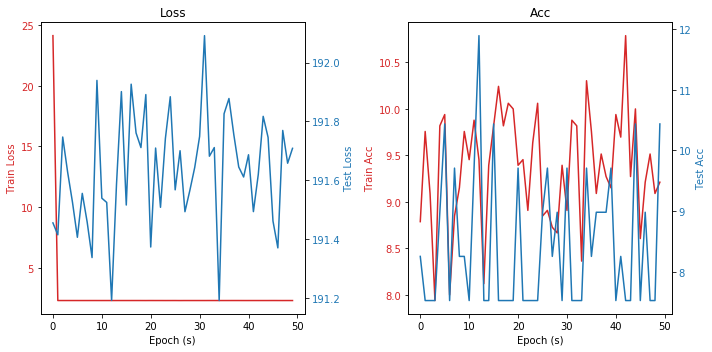

Tarin Max Acc:  10.787878787878787 %. Train Avg. Acc:  9.374545454545453 %
Test Max Acc:  11.893203883495145 %. Test Avg. Acc:  8.441747572815533 %


In [10]:
EPOCH = 50
LR = 0.01
BATCH_SIZE = 5

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)

## 5.6 Tuning CNN

We can change the learning rate first

  0%|          | 0/50 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=16384, out_features=10, bias=True)
)


100%|██████████| 50/50 [00:33<00:00,  1.60it/s]

Training takes:  33.26405191421509


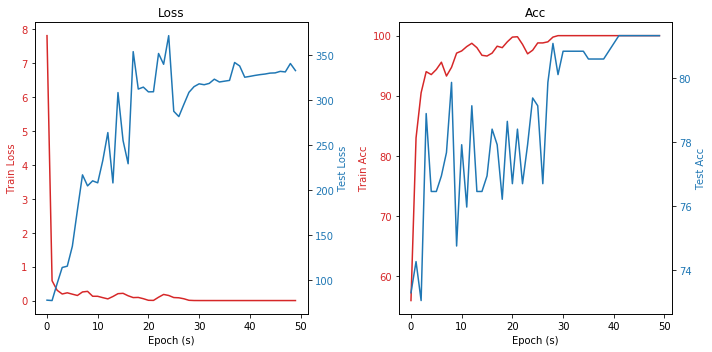

Tarin Max Acc:  100.0 %. Train Avg. Acc:  97.17696969696972 %
Test Max Acc:  81.31067961165049 %. Test Avg. Acc:  78.83495145631066 %


In [11]:
EPOCH = 50
LR = 0.001
BATCH_SIZE = 5


train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)


  0%|          | 0/500 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=16384, out_features=10, bias=True)
)


100%|██████████| 500/500 [05:30<00:00,  1.59it/s]


Training takes:  330.24186515808105


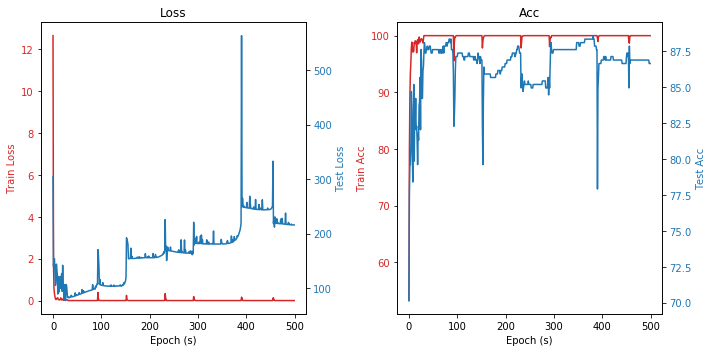

Tarin Max Acc:  100.0 %. Train Avg. Acc:  99.70969696969696 %
Test Max Acc:  88.59223300970874 %. Test Avg. Acc:  86.5757281553398 %


In [12]:
EPOCH = 500
LR = 0.0001
BATCH_SIZE = 5


train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)

  0%|          | 0/500 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=16384, out_features=10, bias=True)
)


100%|██████████| 500/500 [06:09<00:00,  1.12it/s]


Training takes:  369.2961573600769


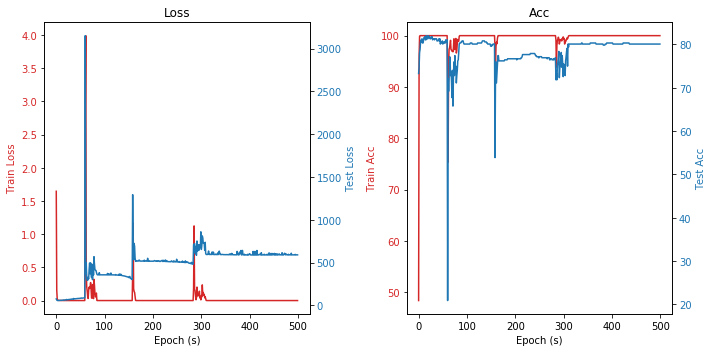

Tarin Max Acc:  100.0 %. Train Avg. Acc:  99.64472727272728 %
Test Max Acc:  82.03883495145631 %. Test Avg. Acc:  78.68446601941748 %


In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(64 * 16 * 16, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
    
EPOCH = 500
LR = 0.001
BATCH_SIZE = 5


train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)










  0%|          | 0/500 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=16384, out_features=10, bias=True)
)


100%|██████████| 500/500 [07:03<00:00,  1.21it/s]


Training takes:  423.3551971912384


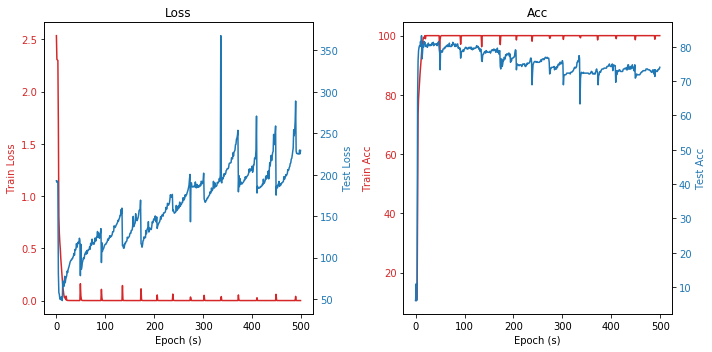

Tarin Max Acc:  100.0 %. Train Avg. Acc:  98.84363636363638 %
Test Max Acc:  83.25242718446601 %. Test Avg. Acc:  75.32038834951457 %


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(64 * 16 * 16, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
    
EPOCH = 500
LR = 0.001
BATCH_SIZE = 5

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)


  0%|          | 0/100 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (liner1): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=1024, out_features=10, bias=True)
)







  1%|          | 1/100 [00:03<06:31,  3.95s/it]


100%|██████████| 100/100 [05:53<00:00,  3.43s/it]


Training takes:  353.3328731060028


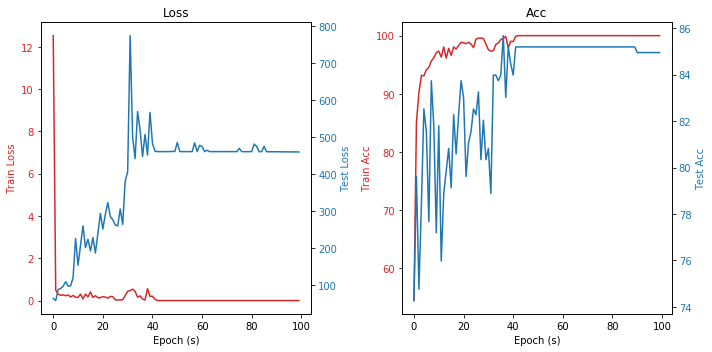

Tarin Max Acc:  100.0 %. Train Avg. Acc:  98.42060606060606 %
Test Max Acc:  85.67961165048544 %. Test Avg. Acc:  83.54611650485437 %


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.liner1 = nn.Sequential(
            nn.Linear(64 * 16 * 16,  1024),
            nn.ReLU()
        )
        self.out = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.liner1(x)
        output = self.out(x)
        return output
    
EPOCH = 100
LR = 0.001
BATCH_SIZE = 5

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)

  0%|          | 0/500 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=8192, out_features=10, bias=True)
)


100%|██████████| 500/500 [07:43<00:00,  1.18it/s]


Training takes:  463.36978125572205


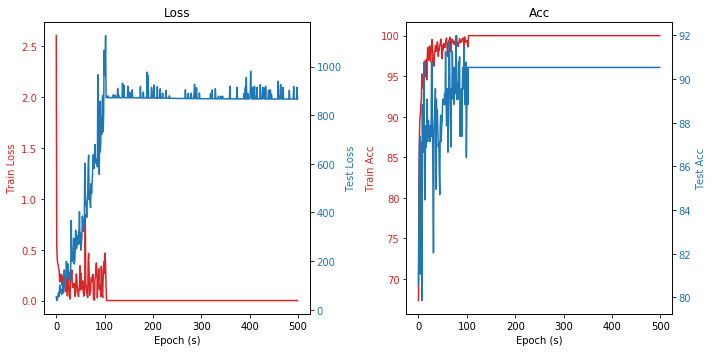

Tarin Max Acc:  100.0 %. Train Avg. Acc:  99.49309090909091 %
Test Max Acc:  91.99029126213593 %. Test Avg. Acc:  90.05873786407764 %


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(128 * 8 * 8, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
    
EPOCH = 500
LR = 0.001
BATCH_SIZE = 5

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)

  0%|          | 0/500 [00:00<?, ?it/s]

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=True)
)


100%|██████████| 500/500 [07:48<00:00,  1.14it/s]

Training takes:  468.5718195438385


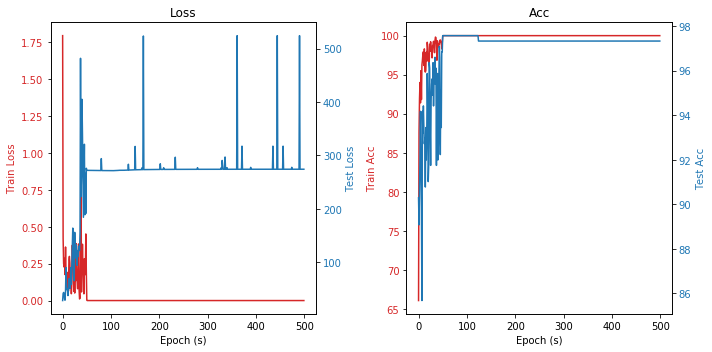

Tarin Max Acc:  100.0 %. Train Avg. Acc:  99.67333333333335 %
Test Max Acc:  97.57281553398059 %. Test Avg. Acc:  97.00776699029126 %


In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(256 * 4 * 4, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
    
EPOCH = 500
LR = 0.001
BATCH_SIZE = 5

train_x, train_y, test_x, test_y = split_train_test_data(X, Y, int(len(Y) * 0.2))
train_loader, test_loader = transform_data(train_x, train_y, test_x, test_y)
cnn, optimizer, loss_function = init_cnn()
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

start_time = time.time()
for epoch in tqdm(range(EPOCH)):
    train_loss, train_acc = train(epoch, cnn, optimizer, loss_function, train_loader)
    test_loss, test_acc = test(epoch, cnn, loss_function, test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
end_time = time.time()
print("Training takes: ", end_time - start_time)

show_result(train_loss_list, test_loss_list, train_acc_list, test_acc_list)